In [47]:
import tensorflow as tf
from keras import models,layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Tomato-Disease-Recognition/PlantVillage/train",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,

)

Found 14529 files belonging to 10 classes.


In [10]:
class_names = dataset.class_names

In [11]:
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [12]:
len(dataset)

455

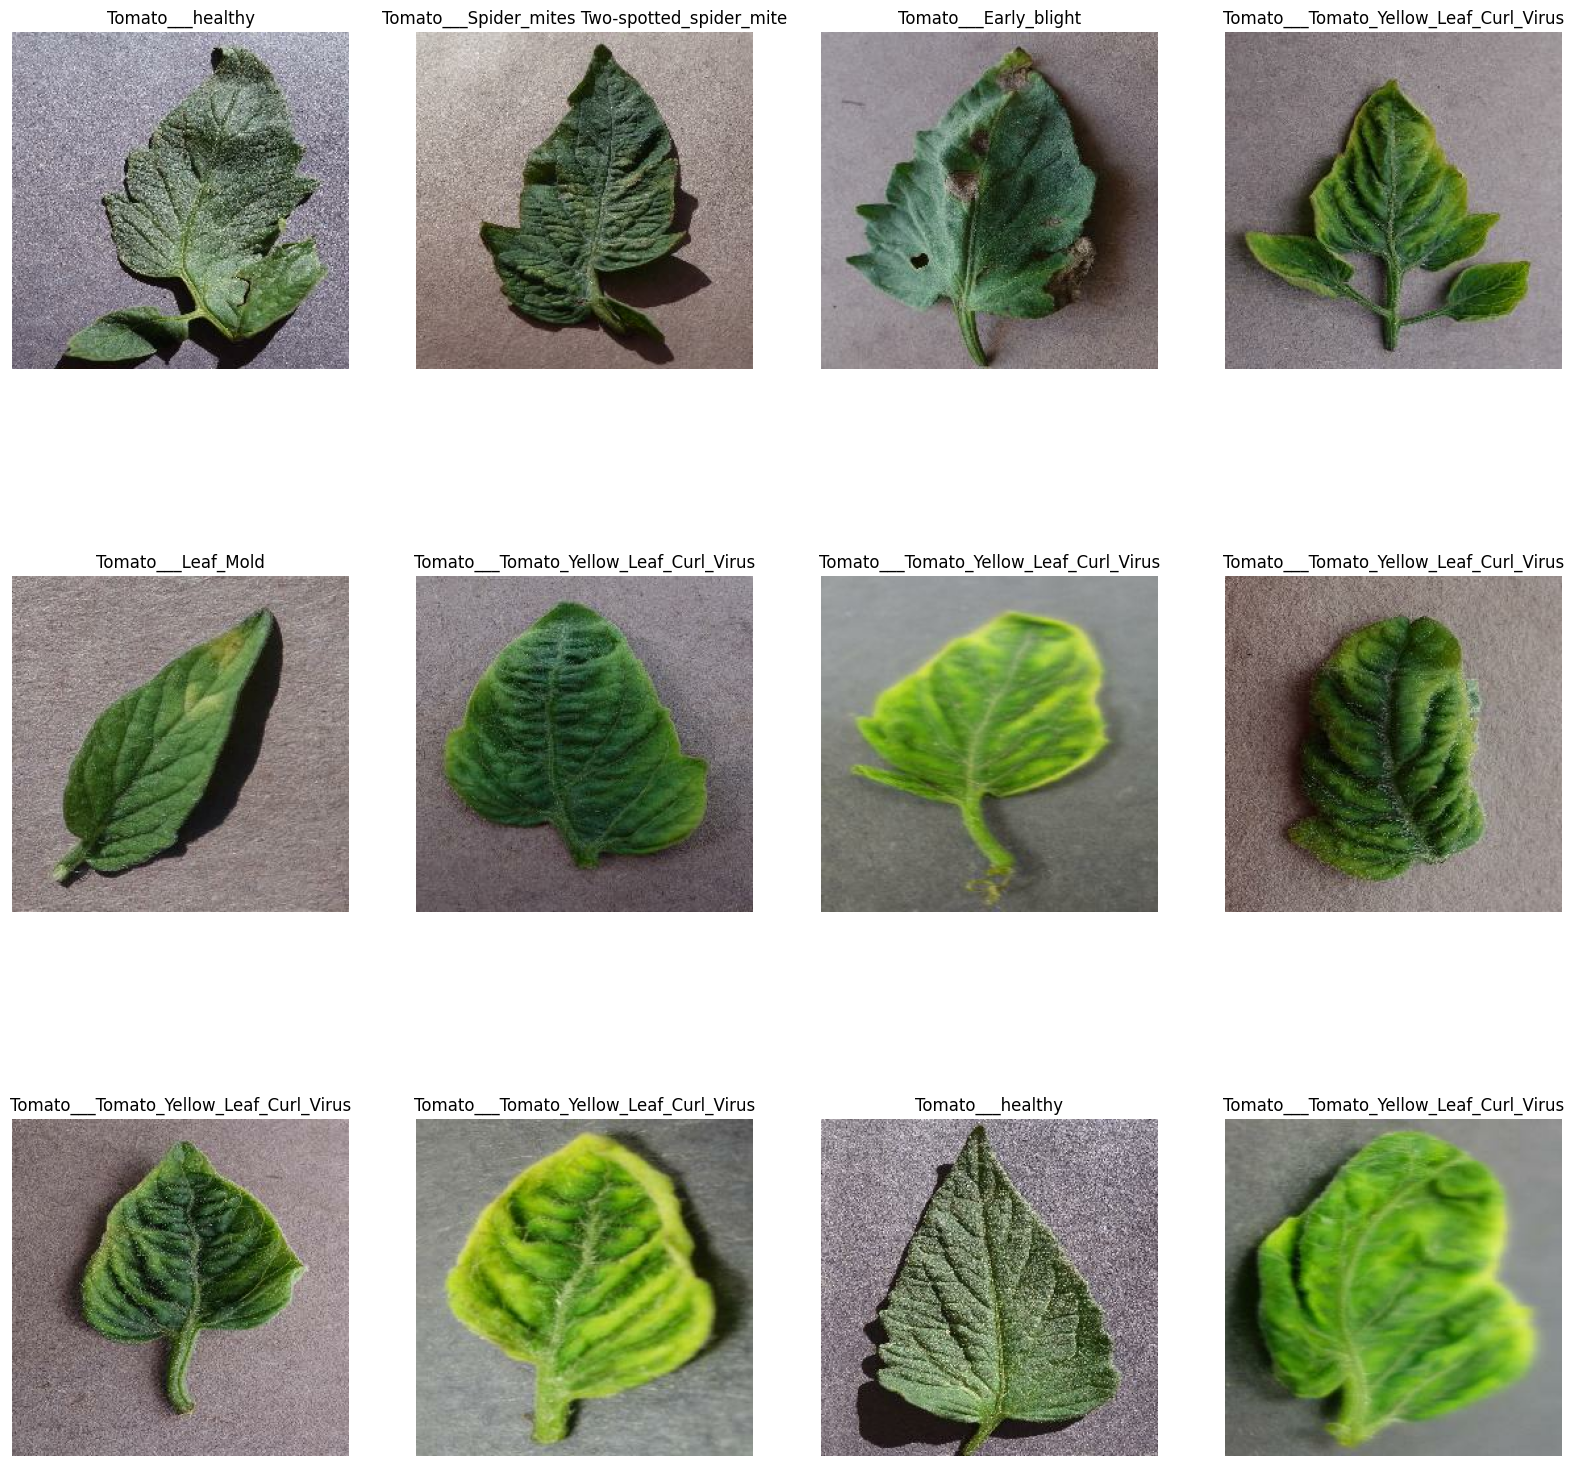

In [32]:
plt.figure(figsize=(20,20))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
  # print(image_batch[0].numpy())
  # print(label_batch)

In [ ]:
#80% training , 10% validation, 10% testing
# train_ds =  dataset.take(len(dataset)*0.8)
# val_and_train_ds = dataset.skip(len(dataset)*0.8)
# val_ds = val_and_train_ds.take(len(val_and_train_ds)*0.5)
# test_ds = val_and_train_ds.skip(len(val_and_train_ds)*0.5)


In [33]:
def get_dataset_partitions_tf(ds,train_split = 0.8, val_split = 0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(ds_size * train_split)
    val_size = int( ds_size * val_split)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [38]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [39]:
len(train_ds)

364

In [40]:
len(val_ds)

45

In [41]:
len(test_ds)

46

In [43]:
# to load the next batch using cpu while the gpu does training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [50]:
#The image given can be off different dimensions so we resize,
# the image has to be converted into grayscale so we rescale
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [51]:
# data augmentation is used, what is does is basically we have images, which we convert into it having horizontal flip, increased contrast, zoom and rotation
# Because we are not sure what device is used to capture the image in our app, it can have different processing done to give varying colors or orientation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])
